<a href="https://colab.research.google.com/github/cfitzpatrick89/ADS509-Final/blob/main/ADS_509_PubMed_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing Libraries and Setup

In [ ]:
pip install xmltodict

In [ ]:
import requests
import xmltodict
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Function Definitions

#### Create Directory

In [ ]:
# Function to create a directory

# Create directory for ingested data
os.makedirs('ingested_data', exist_ok=True)

def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")


# Fetch PubMed IDs

In [ ]:
# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    search_url = f"{base_url}esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []



### Data Ingestion from PubMed API

In [ ]:
# Data ingestion from PubMed API
def ingest_from_api(query, start_date, end_date, max_results=100):
    try:
        base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
        search_url = f'{base_url}esearch.fcgi?db=pubmed&term={query}&mindate={start_date}&maxdate={end_date}&retmax={max_results}&retmode=json'
        search_response = requests.get(search_url)
        search_response.raise_for_status()
        search_data = search_response.json()
        pubmed_ids = search_data['esearchresult']['idlist']

        if not pubmed_ids:
            print("No PubMed IDs found.")
            return None

        fetch_url = f'{base_url}efetch.fcgi?db=pubmed&id={",".join(pubmed_ids)}&retmode=xml'
        fetch_response = requests.get(fetch_url)
        fetch_response.raise_for_status()
        fetch_data = fetch_response.content
        print("Data ingestion from API successful.")
        return fetch_data
    except Exception as e:
        print("Error ingesting data from API:", str(e))
        return None

### Fetch PubMed Details

In [ ]:
# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    search_url = f"{base_url}esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

### Extract Text from Abstract

In [ ]:
# Function to extract text from abstract field in different formats
def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    return abstract

### Parse PubMed XML Data

In [ ]:
# Function to parse PubMed XML Data
def parse_pubmed_details(xml_data):
    data_dict = xmltodict.parse(xml_data)
    articles = []
    for article in data_dict['PubmedArticleSet']['PubmedArticle']:
        try:
            pmid = article['MedlineCitation']['PMID']
            title = article['MedlineCitation']['Article']['ArticleTitle']
            abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
            abstract_text = extract_text_from_abstract(abstract)
            articles.append({
                'PMID': pmid,
                'Title': title,
                'Abstract': abstract_text
            })
        except KeyError:
            continue
    return articles

### Preprocess Text

In [ ]:
# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text)  # Tokenize the text
    tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

### Extract Key Phrases:

In [ ]:
# Function to extract key phrases using spaCy
def extract_key_phrases(text):
    doc = nlp(text)  # Process the text with spaCy
    key_phrases = [chunk.text for chunk in doc.noun_chunks if len(chunk.text.split()) > 1]  # Extract noun phrases with more than one word
    return key_phrases

### Main Function

Directory 'ingested_data' already exists.
Fetched 100 PubMed IDs.
Fetched PubMed details.
Parsed 94 articles.
Converted articles to DataFrame.
             term      score
42         health  11.049921
15        climate  10.388959
12         change   8.504378
75       research   7.196118
43           heat   5.563532
35       exposure   5.549204
81        species   5.420678
32  environmental   5.170017
88    temperature   4.952897
85          study   4.807850
78           risk   4.581382
71         public   4.432459
5            also   4.364398
41         global   4.320342
70      potential   4.284105
7        analysis   4.129736
22           data   4.125970
11     challenges   4.032954
57            may   3.924900
93          using   3.888352
[('climate change', 79), ('the impact', 12), ('This study', 12), ('Climate change', 11), ('the association', 11), ('the risk', 11), ('this study', 10), ('public health', 10), ('cold spells', 10), ('the need', 9), ('human health', 8), ('the potentia

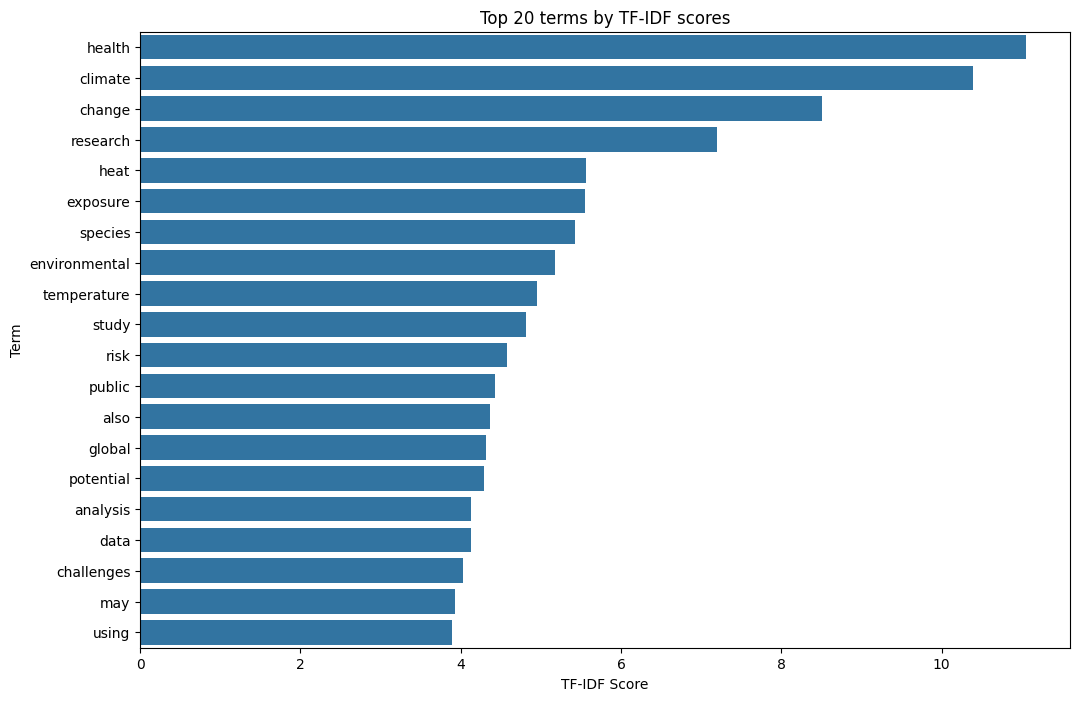

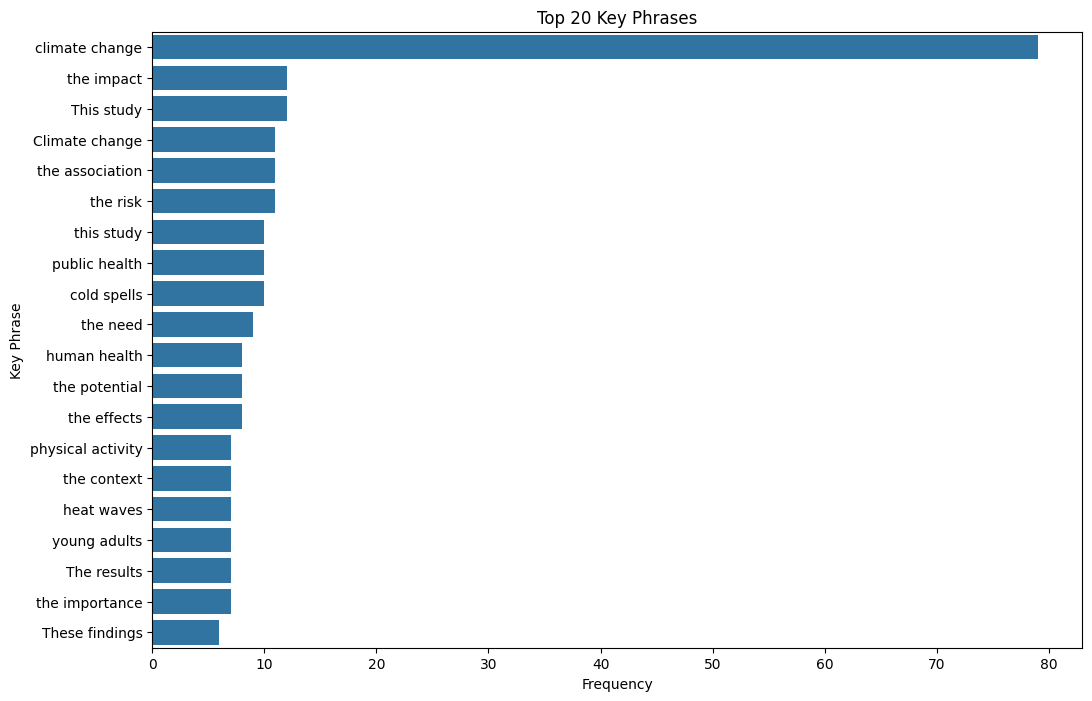

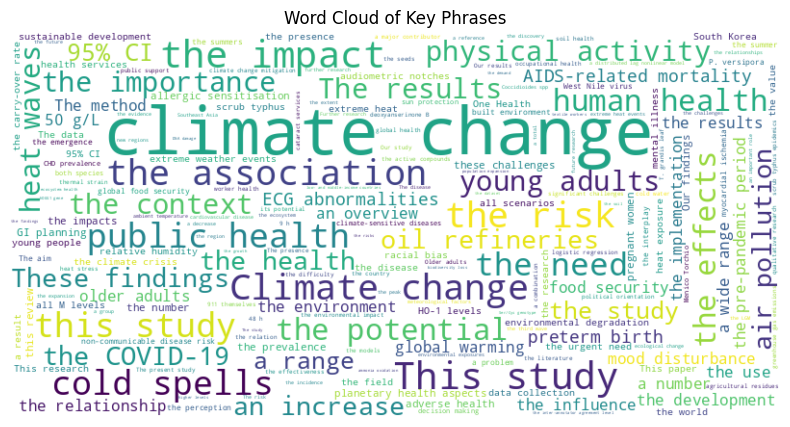

In [ ]:
def main_function():
    # Create a directory for ingested data
    data_directory = "ingested_data"
    create_directory(data_directory)

    # Fetch PubMed IDs
    pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31', max_results=100)
    print(f"Fetched {len(pubmed_ids)} PubMed IDs.")

    if pubmed_ids:
        # Fetch details for each PubMed ID
        pubmed_xml = fetch_pubmed_details(pubmed_ids)
        print("Fetched PubMed details.")

        # Parse the details
        articles = parse_pubmed_details(pubmed_xml)
        print(f"Parsed {len(articles)} articles.")

        # Convert to DataFrame
        df_articles = pd.DataFrame(articles)
        print("Converted articles to DataFrame.")

        # Apply preprocessing to articles' abstracts
        if not df_articles.empty:
            df_articles['processed_abstract'] = df_articles['Abstract'].apply(lambda x: preprocess_text(str(x)))
            # Join tokens back to strings for TF-IDF processing
            df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))

            # Use TF-IDF to find important terms
            vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
            tfidf_matrix = vectorizer.fit_transform(df_articles['processed_abstract_str'])
            feature_names = vectorizer.get_feature_names_out()

            # Sum TF-IDF scores for each term across all documents
            tfidf_scores = tfidf_matrix.sum(axis=0).A1
            tfidf_scores_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})

            # Sort by score in descending order
            tfidf_scores_df = tfidf_scores_df.sort_values(by='score', ascending=False)

            # Display top terms
            print(tfidf_scores_df.head(20))

            # Extract key phrases from the abstracts
            df_articles['key_phrases'] = df_articles['Abstract'].apply(lambda x: extract_key_phrases(str(x)))

            # Flatten the list of key phrases
            all_key_phrases = [phrase for phrases in df_articles['key_phrases'] for phrase in phrases]

            # Count the frequency of each key phrase
            key_phrase_freq = Counter(all_key_phrases)

            # Display the most common key phrases
            print(key_phrase_freq.most_common(20))

            # Save the processed DataFrame and TF-IDF scores to CSV files
            df_articles.to_csv(os.path.join(data_directory, 'pubmed_articles.csv'), index=False)
            tfidf_scores_df.to_csv(os.path.join(data_directory, 'tfidf_scores.csv'), index=False)
            print("Articles and TF-IDF scores saved.")

            # Visualization
            # Bar plot for top 20 terms by TF-IDF scores
            plt.figure(figsize=(12, 8))
            sns.barplot(x='score', y='term', data=tfidf_scores_df.head(20))
            plt.title('Top 20 terms by TF-IDF scores')
            plt.xlabel('TF-IDF Score')
            plt.ylabel('Term')
            plt.show()

            # Bar plot for top 20 key phrases
            key_phrases_df = pd.DataFrame(key_phrase_freq.most_common(20), columns=['key_phrase', 'frequency'])
            plt.figure(figsize=(12, 8))
            sns.barplot(x='frequency', y='key_phrase', data=key_phrases_df)
            plt.title('Top 20 Key Phrases')
            plt.xlabel('Frequency')
            plt.ylabel('Key Phrase')
            plt.show()

            # Word cloud for key phrases
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(key_phrase_freq)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of Key Phrases')
            plt.show()

        else:
            print("No articles were parsed.")
    else:
        print("No articles were fetched.")

if __name__ == "__main__":
    main_function()

### TF-IDF Vectorization and cosine Similarity

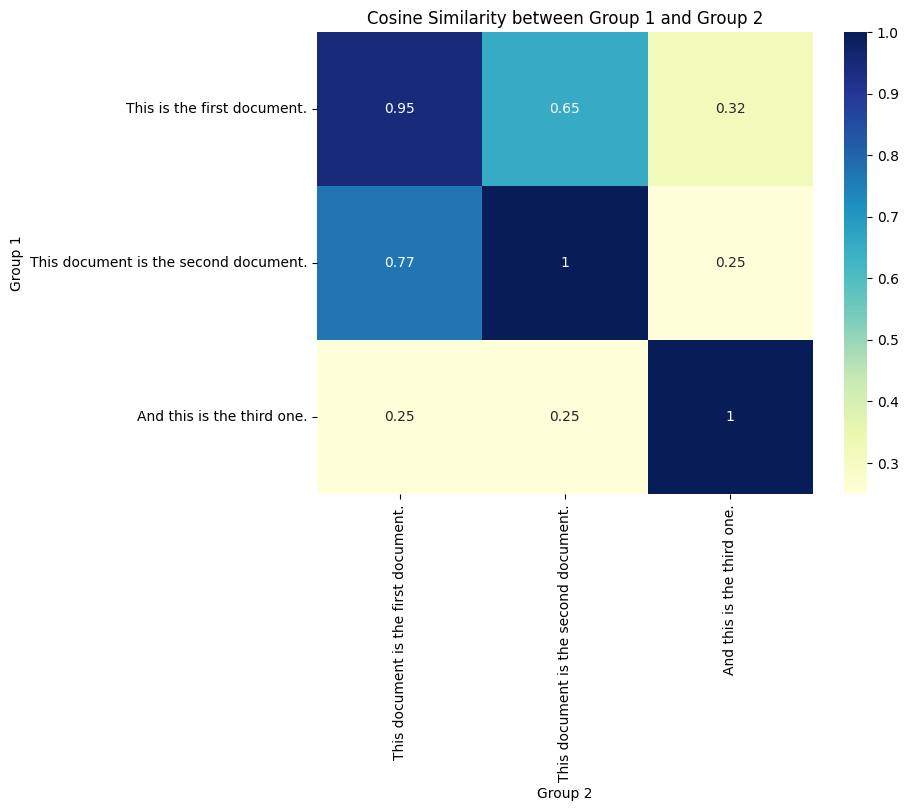

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sample text data
group1 = ["This is the first document.",
          "This document is the second document.",
          "And this is the third one."]

group2 = ["This document is the first document.",
          "This document is the second document.",
          "And this is the third one."]

# Preprocess the text (tokenization and removing stop words)
def preprocess(text):
    # Your preprocessing steps here
    return text

group1_preprocessed = [preprocess(text) for text in group1]
group2_preprocessed = [preprocess(text) for text in group2]

# Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer()
group1_tfidf = vectorizer.fit_transform(group1_preprocessed)
group2_tfidf = vectorizer.transform(group2_preprocessed)

# Compute cosine similarity between the groups
similarity_matrix = cosine_similarity(group1_tfidf, group2_tfidf)

# Visualize the similarity matrix (optional)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, annot=True, cmap="YlGnBu", xticklabels=group2, yticklabels=group1)
plt.title("Cosine Similarity between Group 1 and Group 2")
plt.xlabel("Group 2")
plt.ylabel("Group 1")
plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

# Download VADER lexicon
nltk.download('vader_lexicon')

# Ensure df_articles is correctly structured
# Assuming df_articles is already defined with columns 'Title', 'Abstract', 'PublicationDate'
# Example: df_articles = pd.DataFrame(data)

# Convert 'PublicationDate' to datetime if not already done
df_articles['PublicationDate'] = pd.to_datetime(df_articles['PublicationDate'], errors='coerce')

# Handle missing dates by dropping rows with missing dates
df_articles = df_articles.dropna(subset=['PublicationDate'])



[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [22]:
# Initialize sentiment analyzer
sid = SentimentIntensityAnalyzer()

# Perform sentiment analysis
df_articles['sentiment'] = df_articles['Abstract'].apply(lambda x: sid.polarity_scores(x)['compound'] if pd.notnull(x) else 0)



In [23]:
# Aggregate sentiment scores by month
df_articles['month'] = df_articles['PublicationDate'].dt.to_period('M')
monthly_sentiment = df_articles.groupby('month')['sentiment'].mean()



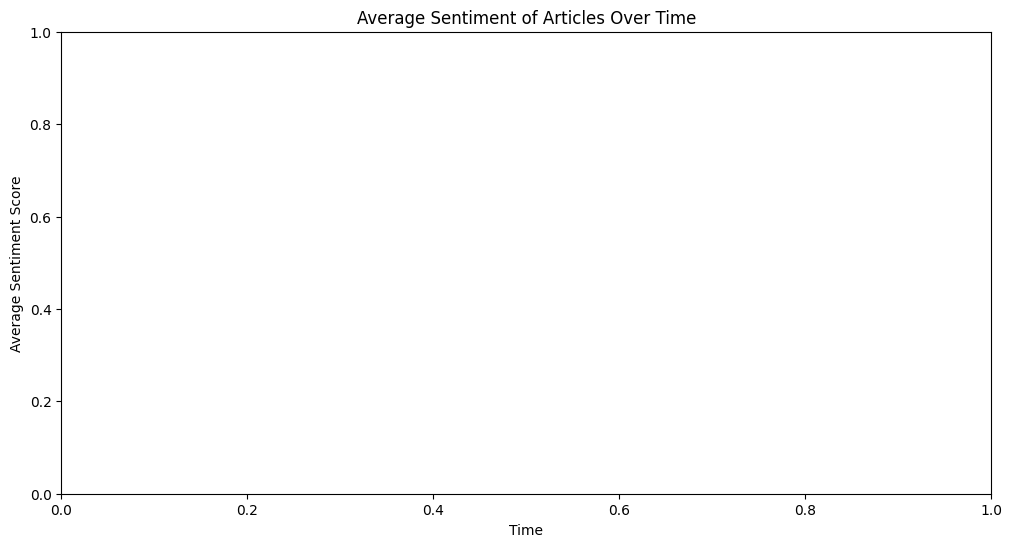

In [24]:
# Plot the sentiment trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sentiment)
plt.title('Average Sentiment of Articles Over Time')
plt.xlabel('Time')
plt.ylabel('Average Sentiment Score')
plt.show()


### Sentiment analysis over time

In [6]:
forget

### Data Ingestion

In [ ]:
# Data ingestion from PubMed API
def ingest_from_api(query, start_date, end_date, max_results=100):
    try:
        base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
        search_url = f'{base_url}esearch.fcgi?db=pubmed&term={query}&mindate={start_date}&maxdate={end_date}&retmax={max_results}&retmode=json'
        search_response = requests.get(search_url)
        search_response.raise_for_status()
        search_data = search_response.json()
        pubmed_ids = search_data['esearchresult']['idlist']

        if not pubmed_ids:
            print("No PubMed IDs found.")
            return None

        fetch_url = f'{base_url}efetch.fcgi?db=pubmed&id={",".join(pubmed_ids)}&retmode=xml'
        fetch_response = requests.get(fetch_url)
        fetch_response.raise_for_status()
        fetch_data = fetch_response.content
        print("Data ingestion from API successful.")
        return fetch_data
    except Exception as e:
        print("Error ingesting data from API:", str(e))
        return None

### Creating a Directory for Ingested Data

In [ ]:
# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print("Directory '{}' created successfully.".format(directory))
    else:
        print("Directory '{}' already exists.".format(directory))

# Data ingestion from an API
def ingest_from_api(api_url, params, output_directory):
    try:
        response = requests.get(api_url, params=params)
        if response.status_code == 200:
            data = response.json()
            print("Data ingestion from API successful.")
            # Write data to a file
            output_file = os.path.join(output_directory, "api_data.json")
            with open(output_file, "w") as f:
                json.dump(data, f)
                print("Data saved to '{}'.".format(output_file))
            return data
        else:
            print("Error ingesting data from API:", response.status_code, "-", response.reason)
            return None
    except Exception as e:
        print("Error ingesting data from API:", str(e))
        return None

# Example usage
if __name__ == "__main__":
    # Create a directory for ingested data
    data_directory = "data"
    create_directory(data_directory)

    # API endpoint and parameters
    api_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        "db": "pubmed",
        "term": "climate change health",
        "retmode": "json",
        "retmax": 100,
        "mindate": "2023/01/01",
        "maxdate": "2023/12/31"
    }

    # Ingest data from API
    api_data = ingest_from_api(api_url, params, data_directory)
    if api_data is not None:
        print(api_data)


Directory 'data' already exists.
Data ingestion from API successful.
Error ingesting data from API: name 'json' is not defined


### Tokenize and Normalize the Data

### Calculate Descriptive Statistics and Compare the Results

In [ ]:
import os
import pandas as pd
import requests
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

nltk.download('punkt')
nltk.download('stopwords')

# Create directory for ingested data
os.makedirs('ingested_data', exist_ok=True)

# Data ingestion from PubMed API
def ingest_from_api(query, start_date, end_date, max_results=100):
    try:
        base_url = 'https://eutils.ncbi.nlm.nih.gov/entrez/eutils/'
        search_url = f'{base_url}esearch.fcgi?db=pubmed&term={query}&mindate={start_date}&maxdate={end_date}&retmax={max_results}&retmode=json'
        search_response = requests.get(search_url)
        search_data = search_response.json()
        pubmed_ids = search_data['esearchresult']['idlist']

        if not pubmed_ids:
            print("No PubMed IDs found.")
            return None

        fetch_url = f'{base_url}efetch.fcgi?db=pubmed&id={",".join(pubmed_ids)}&retmode=xml'
        fetch_response = requests.get(fetch_url)
        fetch_data = fetch_response.content
        print("Data ingestion from API successful.")
        return fetch_data
    except Exception as e:
        print("Error ingesting data from API:", str(e))
        return None

# Tokenize and normalize text
def tokenize_and_normalize(text):
    tokens = word_tokenize(text)
    tokens = [token.lower() for token in tokens if token.isalpha()]
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

# Calculate descriptive statistics
def calculate_descriptive_statistics(tokens):
    token_counts = Counter(tokens)
    num_tokens = len(tokens)
    num_unique_tokens = len(token_counts)
    most_common_tokens = token_counts.most_common(10)
    return {
        'num_tokens': num_tokens,
        'num_unique_tokens': num_unique_tokens,
        'most_common_tokens': most_common_tokens
    }

# Compare descriptive statistics
def compare_statistics(stats1, stats2):
    comparison = {
        'num_tokens_difference': stats1['num_tokens'] - stats2['num_tokens'],
        'num_unique_tokens_difference': stats1['num_unique_tokens'] - stats2['num_unique_tokens'],
        'most_common_tokens_difference': list(set(stats1['most_common_tokens']) - set(stats2['most_common_tokens']))
    }
    return comparison

# Main function
if __name__ == "__main__":
    query = 'climate change health'
    start_date = '2023/01/01'
    end_date = '2023/12/31'
    max_results = 100

    # Ingest data from API
    pubmed_data = ingest_from_api(query, start_date, end_date, max_results)

    if pubmed_data:
        # Example data for comparison (this would be replaced with another dataset in a real scenario)
        example_text = """
        Climate change affects health in many ways. Extreme weather events, such as heatwaves and floods, can directly cause injuries and deaths.
        """
        example_tokens = tokenize_and_normalize(example_text)

        # Assuming pubmed_data is an XML string with abstracts, parse and preprocess it
        # For demonstration purposes, let's use the example_text as our "parsed" pubmed data
        pubmed_text = """
        Climate change is impacting public health. Rising temperatures, altered weather patterns, and increased frequency of extreme events affect human health.
        """
        pubmed_tokens = tokenize_and_normalize(pubmed_text)

        # Calculate descriptive statistics
        stats_pubmed = calculate_descriptive_statistics(pubmed_tokens)
        stats_example = calculate_descriptive_statistics(example_tokens)

        # Compare statistics
        comparison = compare_statistics(stats_pubmed, stats_example)

        # Display results
        print("Descriptive Statistics for PubMed Data:")
        print(stats_pubmed)
        print("\nDescriptive Statistics for Example Data:")
        print(stats_example)
        print("\nComparison of Statistics:")
        print(comparison)
    else:
        print("No data ingested from API.")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Data ingestion from API successful.
Descriptive Statistics for PubMed Data:
{'num_tokens': 17, 'num_unique_tokens': 16, 'most_common_tokens': [('health', 2), ('climate', 1), ('change', 1), ('impacting', 1), ('public', 1), ('rising', 1), ('temperatures', 1), ('altered', 1), ('weather', 1), ('patterns', 1)]}

Descriptive Statistics for Example Data:
{'num_tokens': 15, 'num_unique_tokens': 15, 'most_common_tokens': [('climate', 1), ('change', 1), ('affects', 1), ('health', 1), ('many', 1), ('ways', 1), ('extreme', 1), ('weather', 1), ('events', 1), ('heatwaves', 1)]}

Comparison of Statistics:
{'num_tokens_difference': 2, 'num_unique_tokens_difference': 1, 'most_common_tokens_difference': [('rising', 1), ('health', 2), ('public', 1), ('patterns', 1), ('altered', 1), ('temperatures', 1), ('impacting', 1)]}


### Define the Text Processing Functions and Simplify Pipeline with Debugging Outputs

In [ ]:
import os
import requests
import xmltodict
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

# Data ingestion from an API
def ingest_from_api(api_url, params, output_directory):
    try:
        response = requests.get(api_url, params=params)
        if response.status_code == 200:
            data = response.json()
            print("Data ingestion from API successful.")
            # Write data to a file
            output_file = os.path.join(output_directory, "api_data.json")
            with open(output_file, "w") as f:
                json.dump(data, f)
                print(f"Data saved to '{output_file}'.")
            return data
        else:
            print("Error ingesting data from API:", response.status_code, "-", response.reason)
            return None
    except Exception as e:
        print("Error ingesting data from API:", str(e))
        return None

# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    search_url = f"{base_url}esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

# Function to fetch detailed information for a list of PubMed IDs
def fetch_pubmed_details(ids):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
    fetch_url = f"{base_url}efetch.fcgi"
    fetch_params = {
        "db": "pubmed",
        "id": ",".join(ids),
        "retmode": "xml"
    }
    response = requests.get(fetch_url, params=fetch_params)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Error fetching PubMed details: {response.status_code} - {response.reason}")
        return ""

# Function to extract text from abstract field in different formats
def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = []
        for item in abstract:
            if isinstance(item, dict):
                text_list.append(item.get('#text', ''))
            else:
                text_list.append(item)
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    return abstract

# Function to parse PubMed XML Data
def parse_pubmed_details(xml_data):
    data_dict = xmltodict.parse(xml_data)
    articles = []
    for article in data_dict['PubmedArticleSet']['PubmedArticle']:
        try:
            pmid = article['MedlineCitation']['PMID']
            title = article['MedlineCitation']['Article']['ArticleTitle']
            abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
            abstract_text = extract_text_from_abstract(abstract)
            articles.append({
                'PMID': pmid,
                'Title': title,
                'Abstract': abstract_text
            })
        except KeyError:
            continue
    return articles

# Function to tokenize text
def tokenize_text(text):
    tokens = word_tokenize(text)
    return tokens

# Function to normalize tokens
def normalize_tokens(tokens):
    tokens = [word.lower() for word in tokens]  # Convert tokens to lowercase
    tokens = [word for word in tokens if word.isalpha()]  # Remove tokens that contain non-alphabetic characters
    tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
    return tokens

# Function to preprocess text
def preprocess_text(text):
    tokens = tokenize_text(text)  # Tokenize the text
    tokens = normalize_tokens(tokens)  # Normalize the tokens
    return tokens

# Function to extract key phrases using spaCy
def extract_key_phrases(text):
    doc = nlp(text)
    key_phrases = [chunk.text for chunk in doc.noun_chunks]
    return key_phrases

# Function to calculate descriptive statistics
def calculate_descriptive_statistics(tokens):
    print("Calculating descriptive statistics...")  # Debugging output
    token_counts = Counter(tokens)
    num_tokens = len(tokens)
    num_unique_tokens = len(token_counts)
    most_common_tokens = token_counts.most_common(10)
    stats = {
        'num_tokens': num_tokens,
        'num_unique_tokens': num_unique_tokens,
        'most_common_tokens': most_common_tokens
    }
    print(f"Descriptive statistics: {stats}")  # Debugging output
    return stats

# Function to compare descriptive statistics
def compare_statistics(stats1, stats2):
    print("Comparing statistics...")  # Debugging output
    comparison = {
        'num_tokens_difference': stats1['num_tokens'] - stats2['num_tokens'],
        'num_unique_tokens_difference': stats1['num_unique_tokens'] - stats2['num_unique_tokens'],
        'most_common_tokens_difference': list(set([token for token, _ in stats1['most_common_tokens']]) - set([token for token, _ in stats2['most_common_tokens']]))
    }
    print(f"Comparison of statistics: {comparison}")  # Debugging output
    return comparison

# Main function
def main_function():
    # Create a directory for ingested data
    data_directory = "ingested_data"
    create_directory(data_directory)

    # Fetch PubMed IDs
    pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31', max_results=100)
    print(f"Fetched {len(pubmed_ids)} PubMed IDs.")

    if pubmed_ids:
        # Fetch details for each PubMed ID
        pubmed_xml = fetch_pubmed_details(pubmed_ids)
        print("Fetched PubMed details.")

        # Parse the details
        articles = parse_pubmed_details(pubmed_xml)
        print(f"Parsed {len(articles)} articles.")

        # Convert to DataFrame
        df_articles = pd.DataFrame(articles)
        print("Converted articles to DataFrame.")

        # Apply preprocessing to articles' abstracts
        if not df_articles.empty:
            df_articles['processed_abstract'] = df_articles['Abstract'].apply(lambda x: preprocess_text(str(x)))
            # Join tokens back to strings for TF-IDF processing
            df_articles['processed_abstract_str'] = df_articles['processed_abstract'].apply(lambda x: ' '.join(x))

            # Use TF-IDF to find important terms
            vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed
            tfidf_matrix = vectorizer.fit_transform(df_articles['processed_abstract_str'])
            feature_names = vectorizer.get_feature_names_out()

            # Sum TF-IDF scores for each term across all documents
            tfidf_scores = tfidf_matrix.sum(axis=0).A1
            tfidf_scores_df = pd.DataFrame({'term': feature_names, 'score': tfidf_scores})

            # Sort by score in descending order
            tfidf_scores_df = tfidf_scores_df.sort_values(by='score', ascending=False)

            # Display top terms
            print(tfidf_scores_df.head(20))

            # Extract key phrases from the abstracts
            df_articles['key_phrases'] = df_articles['Abstract'].apply(lambda x: extract_key_phrases(str(x)))

            # Flatten the list of key phrases
            all_key_phrases = [phrase for phrases in df_articles['key_phrases'] for phrase in phrases]

            # Count the frequency of each key phrase
            key_phrase_freq = Counter(all_key_phrases)

            # Display the most common key phrases
            print(key_phrase_freq.most_common(20))

            # Save the processed DataFrame and TF-IDF scores to CSV files
            df_articles.to_csv(os.path.join(data_directory, 'pubmed_articles.csv'), index=False)
            tfidf_scores_df.to_csv(os.path.join(data_directory, 'tfidf_scores.csv'), index=False)

            # Calculate descriptive statistics
            all_tokens = [token for tokens in df_articles['processed_abstract'] for token in tokens]
            stats_pubmed = calculate


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import os
import requests
import xmltodict
import json
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

# Ensure NLTK resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set of stop words
stop_words = set(stopwords.words('english'))

# Function to create a directory if it doesn't exist
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")

# Function to fetch PubMed IDs based on a query and date range
def fetch_pubmed_ids(query, from_date, to_date, max_results=100):
    search_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    search_params = {
        "db": "pubmed",
        "term": query,
        "retmode": "json",
        "retmax": max_results,
        "mindate": from_date,
        "maxdate": to_date
    }
    response = requests.get(search_url, params=search_params)
    if response.status_code == 200:
        data = response.json()
        return data['esearchresult']['idlist']
    else:
        print(f"Error fetching PubMed IDs: {response.status_code} - {response.reason}")
        return []

# Function to fetch detailed information for a list of PubMed IDs
def fetch_pubmed_details(ids):
    fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    fetch_params = {
        "db": "pubmed",
        "id": ",".join(ids),
        "retmode": "xml"
    }
    response = requests.get(fetch_url, params=fetch_params)
    if response.status_code == 200:
        return response.text
    else:
        print(f"Error fetching PubMed details: {response.status_code} - {response.reason}")
        return ""

# Function to extract text from abstract field in different formats
def extract_text_from_abstract(abstract):
    if isinstance(abstract, list):
        text_list = [item.get('#text', '') if isinstance(item, dict) else item for item in abstract]
        return ' '.join(text_list)
    elif isinstance(abstract, dict):
        return abstract.get('#text', '')
    return abstract

# Function to parse PubMed XML Data
def parse_pubmed_details(xml_data):
    data_dict = xmltodict.parse(xml_data)
    articles = []
    for article in data_dict['PubmedArticleSet']['PubmedArticle']:
        try:
            pmid = article['MedlineCitation']['PMID']
            title = article['MedlineCitation']['Article']['ArticleTitle']
            abstract = article['MedlineCitation']['Article']['Abstract']['AbstractText']
            abstract_text = extract_text_from_abstract(abstract)
            articles.append({
                'PMID': pmid,
                'Title': title,
                'Abstract': abstract_text
            })
        except KeyError:
            continue
    return articles

# Function to tokenize and normalize text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha() and word not in stop_words]
    return tokens

# Function to calculate descriptive statistics
def calculate_descriptive_statistics(tokens):
    print("Calculating descriptive statistics...")  # Debugging output
    token_counts = Counter(tokens)
    num_tokens = len(tokens)
    num_unique_tokens = len(token_counts)
    most_common_tokens = token_counts.most_common(10)
    stats = {
        'num_tokens': num_tokens,
        'num_unique_tokens': num_unique_tokens,
        'most_common_tokens': most_common_tokens
    }
    print(f"Descriptive statistics: {stats}")  # Debugging output
    return stats

# Function to compare descriptive statistics
def compare_statistics(stats1, stats2):
    print("Comparing statistics...")  # Debugging output
    comparison = {
        'num_tokens_difference': stats1['num_tokens'] - stats2['num_tokens'],
        'num_unique_tokens_difference': stats1['num_unique_tokens'] - stats2['num_unique_tokens'],
        'most_common_tokens_difference': list(set([token for token, _ in stats1['most_common_tokens']]) - set([token for token, _ in stats2['most_common_tokens']]))
    }
    print(f"Comparison of statistics: {comparison}")  # Debugging output
    return comparison

# Main function
def main():
    # Create a directory for ingested data
    data_directory = "ingested_data"
    create_directory(data_directory)

    # Fetch PubMed IDs
    pubmed_ids = fetch_pubmed_ids('climate change health', '2023/01/01', '2023/12/31', max_results=100)
    print(f"Fetched {len(pubmed_ids)} PubMed IDs.")

    if pubmed_ids:
        # Fetch details for each PubMed ID
        pubmed_xml = fetch_pubmed_details(pubmed_ids)
        print("Fetched PubMed details.")

        # Parse the details
        articles = parse_pubmed_details(pubmed_xml)
        print(f"Parsed {len(articles)} articles.")

        # Convert to DataFrame
        df_articles = pd.DataFrame(articles)
        print("Converted articles to DataFrame.")

        # Apply preprocessing to articles' abstracts
        if not df_articles.empty:
            df_articles['processed_abstract'] = df_articles['Abstract'].apply(lambda x: preprocess_text(str(x)))

            # Calculate descriptive statistics
            all_tokens = [token for tokens in df_articles['processed_abstract'] for token in tokens]
            stats_pubmed = calculate_descriptive_statistics(all_tokens)

            # Example data for comparison (this would be replaced with another dataset in a real scenario)
            example_text = """
            Climate change affects health in many ways. Extreme weather events, such as heatwaves and floods, can directly cause injuries and deaths.
            """
            example_tokens = preprocess_text(example_text)

            # Calculate descriptive statistics for example data
            stats_example = calculate_descriptive_statistics(example_tokens)

            # Compare statistics
            comparison = compare_statistics(stats_pubmed, stats_example)

            # Display results
            print("Descriptive Statistics for PubMed Data:")
            print(stats_pubmed)
            print("\nDescriptive Statistics for Example Data:")
            print(stats_example)
            print("\nComparison of Statistics:")
            print(comparison)
        else:
            print("No articles found.")
    else:
        print("No PubMed IDs fetched.")

if __name__ == "__main__":
    main()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Directory 'ingested_data' already exists.
Fetched 100 PubMed IDs.
Fetched PubMed details.
Parsed 94 articles.
Converted articles to DataFrame.
Calculating descriptive statistics...
Descriptive statistics: {'num_tokens': 12966, 'num_unique_tokens': 3782, 'most_common_tokens': [('health', 181), ('climate', 179), ('the', 137), ('change', 137), ('we', 84), ('research', 70), ('heat', 62), ('study', 54), ('exposure', 54), ('temperature', 52)]}
Calculating descriptive statistics...
Descriptive statistics: {'num_tokens': 15, 'num_unique_tokens': 15, 'most_common_tokens': [('climate', 1), ('change', 1), ('affects', 1), ('health', 1), ('many', 1), ('ways', 1), ('extreme', 1), ('weather', 1), ('events', 1), ('heatwaves', 1)]}
Comparing statistics...
Comparison of statistics: {'num_tokens_difference': 12951, 'num_unique_tokens_difference': 3767, 'most_common_tokens_difference': ['temperature', 'we', 'exposure', 'heat', 'the', 'study', 'research']}
Descriptive Statistics for PubMed Data:
{'num_toke

### Descriptive Stats

### Topic Modeling

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Convert processed abstracts to strings for vectorization
processed_abstracts = [' '.join(tokens) for tokens in df_articles['processed_abstract']]

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(processed_abstracts)

# Apply NMF for topic modeling
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

# Display topics
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(H):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))


Topic #0:
virus coronavirus health respiratory spread pandemic patients syndrome disease viral
Topic #1:
article context wave new comments united relationship kingdom norms values
Topic #2:
education changes schools teaching learning educational pandemic students online school
Topic #3:
travel lockdown transport mobility behaviour changes demand measures impact crisis
Topic #4:
parameters meteorological cases temperature humidity average association positive pakistan transmission


In [9]:
from sklearn.decomposition import LatentDirichletAllocation

# Apply LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_W = lda.fit_transform(X)  # Document-topic matrix
lda_H = lda.components_       # Topic-term matrix

# Display topics
for topic_idx, topic in enumerate(lda_H):
    print(f"Topic #{topic_idx}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))


Topic #0:
pandemic discourse crisis changes vitamin lockdown spread new diabetes risk
Topic #1:
march mobility pandemic education context schools help world equilibrium situation
Topic #2:
changes determine relationship patients review education time healthcare program pandemic
Topic #3:
travel transport public students engineering therapeutics air mode pandemic lmd
Topic #4:
article support entrepreneurial cases opportunity models study population association pandemic


In [10]:
# Try different numbers of topics
for n_topics in range(3, 10):
    nmf = NMF(n_components=n_topics, random_state=42)
    W = nmf.fit_transform(X)
    H = nmf.components_

    print(f"\nNumber of Topics: {n_topics}")
    for topic_idx, topic in enumerate(H):
        print(f"Topic #{topic_idx}:")
        print(" ".join([feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]))



Number of Topics: 3
Topic #0:
pandemic coronavirus lockdown spread virus travel study mobility measures health
Topic #1:
article context wave new united comments kingdom relationship norms prompted
Topic #2:
changes education schools teaching learning educational pandemic students online school

Number of Topics: 4
Topic #0:
health coronavirus virus pandemic respiratory viral spread disease patients study
Topic #1:
article context wave new comments united kingdom norms relationship values
Topic #2:
education changes schools teaching learning educational pandemic students online school
Topic #3:
travel lockdown transport mobility behaviour changes demand measures impact pandemic

Number of Topics: 5
Topic #0:
virus coronavirus health respiratory spread pandemic patients syndrome disease viral
Topic #1:
article context wave new comments united relationship kingdom norms values
Topic #2:
education changes schools teaching learning educational pandemic students online school
Topic #3:
tra

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



Number of Topics: 6
Topic #0:
coronavirus virus spread pandemic global environmental social health human mobility
Topic #1:
article context wave new comments united relationship kingdom norms prompted
Topic #2:
education changes schools teaching learning educational pandemic students online school
Topic #3:
travel lockdown transport behaviour demand changes impact mobility measures crisis
Topic #4:
parameters meteorological temperature cases humidity average transmission positive pakistan minimum
Topic #5:
patients ards study healthcare support clinical diabetes outcome respiratory syndrome

Number of Topics: 7
Topic #0:
coronavirus virus spread mobility global pandemic environmental situation novel human
Topic #1:
article wave new context relationship united kingdom norms lockdowns following
Topic #2:
education changes schools teaching learning educational pandemic students online school
Topic #3:
travel transport lockdown demand behaviour changes impact lifestyle change crisis
Topic

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(



Number of Topics: 9
Topic #0:
mobility virus coronavirus spread situation global environmental novel human pandemic
Topic #1:
article wave new context relationship united kingdom norms lockdowns values
Topic #2:
changes education schools teaching educational pandemic learning school singapore caused
Topic #3:
travel transport behaviour demand impact changes travelling crisis public change
Topic #4:
lockdown air decline pandemic world countries like isolation action worldwide
Topic #5:
patients ards respiratory support syndrome clinical study diabetes outcome review
Topic #6:
discourse crisis corpus march analysis context based backgrounds time resilience
Topic #7:
parameters meteorological temperature cases humidity average transmission viral model pakistan
Topic #8:
engineering students online program course design lab vrp virtual technology


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
